In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from plotnine import *
from numpy.linalg import *
pd.set_option('display.max_rows', 101)


import warnings

from mizani.formatters import percent_format, custom_format, scientific_format
from mizani.formatters import scientific_format
from mizani.transforms import trans, trans_new

warnings.filterwarnings('ignore')

from IPython.display import display
pd.set_option('display.notebook_repr_html', True)


def _repr_latex_(self):
    return self.to_latex()

pd.DataFrame._repr_latex_ = _repr_latex_  # monkey patch pandas DataFrame

pd.set_option('display.width',None)


**9.** implement ‘fit linear regression‘ function.

In [2]:
def fit_linear_regression(X, y):
    """
    fit linear regression model and get the coefficients 
    :param X: numpy array with p rows and n columns (p x n matrix)
    :param y: numpy array with n rows
    :return: w -  numpy array of the coefficients vector
             D - numpy array of the singular values of X.
    """
    w = pinv(X.T) @ y
    D = svd(X,compute_uv=False)
        
    return (w, D)



**10.** implement ‘predict‘ function.

In [3]:
def predict(X, w):
    """
    predict linear regression fitted values
    :param X: numpy array with p rows and n columns (p x n matrix)
    :param w: numpy array with p columns
    :return: y_hat - a numpy array with the predicted value by the model
    """
    y_hat = X.T @ w
    return y_hat
    

**11.** implement ‘mse‘ function.

In [4]:
def mse(y, y_hat):
    """
    predict linear regression fitted values
    :param y: response vector (numpy array with length n)
    :param y_hat: prediction vector (numpy array with length n)
    :return: mse - the MSE over the received samples (scalar)
    """
    mse = ((y - y_hat)**2).mean()

    return mse
    

**12. Implement a function called ‘load data‘ the given a path to the csv file loads the dataset and performs all the needed preprocessing so to get a valid design matrix. The function returns the dataset after the preprocessing.**

In the following task we will pre-proccess our data, and after we'll finish, we will create the 'load_data' function that is loading the proccessed data.

I will try to make this procedure as detailed as possible, and give reasons for every decision I made while explaining the way of thinking.

In [5]:
data = pd.read_csv("kc_house_data.csv")

We can see here the different columns. We have continous variables, strings (date), discrete ordinal variables (as condition, floors, grade, view, etc.), dummies (waterfront), and categorical (zipcode).

Our mission is to build a linear model for the house price, and therefor the 'price' column is our explanatory variable.

Before we start, let's look up for missing values:

In [6]:
#print all rows contain null in any column
nulldf = data[data.isna().any(axis=1)]


display(nulldf.T)  # OR




,10816,14900,16654,20386,20672
id,1.22304e+09,NaN,NaN,1.22203e+09,0
date,NaN,20141203T000000,20140605T000000,20140626T000000,0
price,605000,430000,355500,NaN,0
bedrooms,5,3,3,3,0
bathrooms,2.75,2.25,2.5,1.75,0
sqft_living,2910,1830,2600,1444,0
sqft_lot,13332,19965,5540,249126,0
floors,2,1,2,1.5,0
waterfront,0,0,0,0,0
view,0,0,0,0,NaN


We can see that we have some missing values in our data. Values with missing id's are okay (rows 14900 and 16654) , since the id is an arbitrary index, and we will remove it later. Moreover, we have one row with zeros and nan values (20672) , which seems like a by-product of our data and can be removed.

We still have two rows to handle: row 10816 with a missing date, and row 20386 with a missing price. Since price is our explanatory variable, the missing price observation (row) can be removed, and we might want to use it later to model our test.

There are different approaches to handle the missing date value, as in row 10816. We can either fill it with the most common date (later we will covnvert the date to month and year), or create a regression model with date as the explanatory variable and try predict it. Since we just started to learn this subject, and since we have a lot of more observations, for now i would carefully say that it might be not too bad to delete this observation.

So in conclusion, we will remove all the rows that have nan values in non-id places. In other words let us first remove the id column from our data, and remove the remaining rows after.

In [7]:
#drop id column
data = data.drop(['id'],axis=1)
#drop all rows contains any nan values.
data = data.dropna()

Our next step will be finding some weird and exceptional values. First we'll have a look on our data distribution, using the describe() function. Note that since the date variable is a string, it won't be shown on the describe. We will handle it later.

In [8]:
#print description of our data
display(np.round(data.describe().T,3).iloc[:,1:])

,mean,std,min,25%,50%,75%,max
price,540001.180,367256.535,-690500.000,321500.000,450000.000,645000.000,7700000.000
bedrooms,3.371,0.930,0.000,3.000,3.000,4.000,33.000
bathrooms,2.115,0.770,0.000,1.750,2.250,2.500,8.000
sqft_living,2079.842,918.549,0.000,1425.000,1910.000,2550.000,13540.000
sqft_lot,15095.104,41390.081,0.000,5040.000,7617.000,10685.000,1651359.000
floors,1.494,0.540,0.000,1.000,1.500,2.000,3.500
waterfront,0.008,0.087,0.000,0.000,0.000,0.000,1.000
view,0.234,0.766,0.000,0.000,0.000,0.000,4.000
condition,3.409,0.651,0.000,3.000,3.000,4.000,5.000
grade,7.657,1.177,0.000,7.000,7.000,8.000,13.000


The first thing that stands out from the table above, is that we that **maximum observation for bedrooms is 33**, which is quite weird. This time, my first guess is that 33 is a typo, and the original rooms number was 3. Therefor, We can compare the house properties (the built part of the house only, since we don't care about the rest) and see if it it similar to the group mean.



In [9]:
#create a row that shows the 33 bedrooms house
beds_33 = data.loc[(data['bedrooms']==33)].T[1:]
#create a row that shows 3 bedrooms houses means
mean_3 = data.loc[(data['bedrooms']==3)].mean().round(2)
#create a row that shows 3 bedrooms houses standart variations
sd_3 = data.loc[(data['bedrooms']==3)].std().round(2)
#join these rows to a dataframe
show33 = pd.concat([beds_33,mean_3 ,sd_3], axis=1)
#show relevant variables we want to check
show33 = show33.iloc[[0,1,2,3,5]].T.rename(index={0: '3 rooms mean',15870:'33 rooms house',1:'3 rooms sd'})
#display
display(show33)

,price,bedrooms,bathrooms,sqft_living,floors
33 rooms house,640000,33,1.75,1620,1
3 rooms mean,466209,3,1.97,1805.87,1.45
3 rooms sd,262518,0,0.63,623.14,0.56


I believe that by this comparison, we can say cautiously that 33 was a typo, and the original value was supposed to be 3.

In [10]:
#change 33 bedrooms typo to 3
data.bedrooms.loc[(data['bedrooms']==33)] = 3

We can also tell that yr_renovated (last time house was renovated) can be 0. I guess this can cause a big variance in this variable, and we want to make it smaller. My first thought was to create a dummy variable that tells if house was ever renoveated (if not, yr_renovated is 0), but is renovation in 1970 is as same as renovation at 2010? 

Than I thought maybe replace the year renovation zeros with year_built, but I didn't because of multicollinearity considerations.

Finally, I decided to create a "renovation rank": 
If house was never renovated, the renovation rank would be 0. 1 is for houses renovated before 1970, 2 is for 1970-1979, 3 is for 1980-1989 and 4 is for 1990-1999, and 5 is for newer renovations. I know that it is a bit patchy, but that was my decision.


In [11]:
#create a renovation rank function
def renovation_rank(yr_ren):
    if (yr_ren == 0):
        return 0
    if(yr_ren < 1970):
        return 1
    if(yr_ren < 1980):
        return 2
    if(yr_ren < 1990):
        return 3
    if(yr_ren < 2000):
        return 4
    else: 
        return 5


#apply renovation rank    
data['renovation'] = data.yr_renovated.apply(renovation_rank)

#drop year renovation column
data = data.drop(['yr_renovated'],axis=1)


In [12]:
#check if all sums of basement and above sqft's equal to living sqft
(data['sqft_basement'] + data['sqft_above'] == data['sqft_living']).all()

True

After varifying that sqft_basement + sqft_above equals to sqft_living in all our houses (see code), we can say that this three columns are not dependent and try fixing it.
My decision was removing sqft_basement, because some houses have no basement at all.

In [13]:
data = data.drop(['sqft_basement'],axis=1)

In our price vector, we can see that the minimum price is negative, which must be a mistake. Let's have a close look on the price distribution with a histogram.

AxesSubplot(0.125,0.125;0.775x0.755)


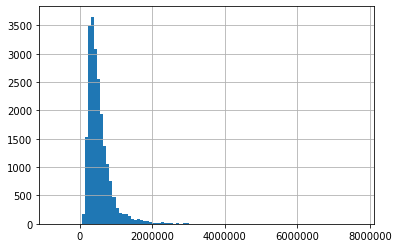

In [14]:
#plot a histogram of the price variable
print(data.price.hist(bins=100))

It seems that we have some really low values in our price vector. Let's see how many non-positive values we have in our dataframe.

In [15]:
#view rows where price <= 0
print(data.price[data.price<=0])

6383    -690500.0
15504         0.0
20671         0.0
Name: price, dtype: float64


So, we have 3 0 values, and a negative value.
In a closer look on the negative-price observation, we can guess (by the prices distribution and by the house other specs) that this price is just a typo, and fix it to 690500.

In [16]:
#change value to positive
data.price.iloc[6383] *= -1

We also have three 0 values. Since the price is what we try to predict, we can either delete those rows, or put the average instaed. My decision is to delete these rows.

In [17]:
#drop rows where price == 0
data = data.drop(data.price[data.price==0].index,axis=0)

In the next level, we will handle our date variable. We can see that the date format is unnessecary for us. In fact, since time can be measured as "distance from day zero", we can treat our sale date as the distance from the first house sale.

In [18]:
#convert date from string to datetime
data.date = pd.to_datetime((data.date).str[:8])
#create time_delta column
data['timedelta'] = (data.date - data.date.min() ).astype('timedelta64[D]')
#remove original date column
data = data.drop(['date'],axis=1)



**13. Dealing with categorical variables**

Another interesting variable in our data, is the zipcode. The zipcode is a categorical variable, means that it is discrete and not ordinal. Therefor, as described on the class forum, we can change it to dummy variables. Since we have 70 unique zipcodes, first we want to check that the zipcode is really affecting the price, and worth all the trouble. We can create a boxplot of the zipcodes vs. price and check it out

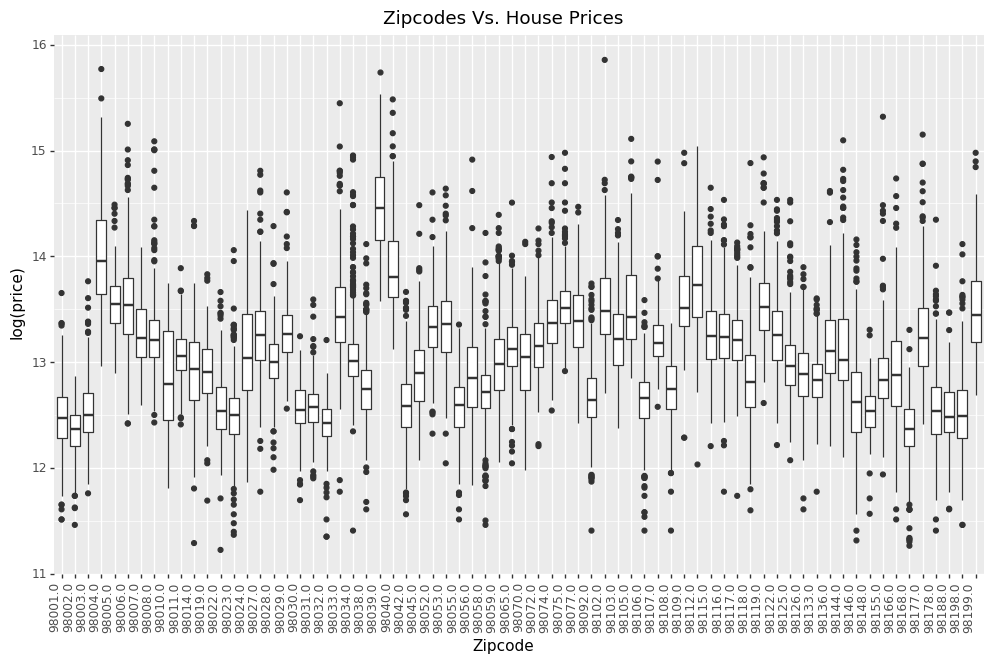

In [19]:
#create ggplot object
g = ggplot(pd.DataFrame({'y':np.log(data.price), 'x':data.zipcode.astype('category')})) +\
 geom_boxplot(aes(x='x',y='y')) +\
 theme(axis_text_x=element_text(rotation=90, hjust=1),figure_size=(12, 7)) +\
 labs(x="Zipcode",y="log(price)", title= "Zipcodes Vs. House Prices")

g.draw();

It seems from the plot that the zipcode affects the price,and some areas are chaper/more expensive compare to others. So in my opinion, we should create zipcode dummies.

In [20]:
#create dummy variables from zipcodes
zip_dum = pd.get_dummies(data.zipcode, drop_first=True)
#drop original zipcode column
data = data.drop('zipcode',axis = 1)
#add dummies to data
data = data.join(zip_dum)

As a final step, we will create our data matrix X and our response vector y, In three steps:

1. create y: numpy array from the price column
2. create X: numpy array size pxn from the rest of our dataframe.
3. create a vector of ones, and add it to our dataframe so we'll have a intercept in our model.

In [21]:
y = data.price.values
ones = np.ones(len(y))
Xt_df = data.drop(['price'],axis=1)
X = np.row_stack((ones,Xt_df.T))

Now, we can add all this together to our function, load_data()

In [22]:
def load_data(path):
    """
    Loads the dataset and performs all the needed preprocessing so to get a valid design matrix. 
    The function returns the dataset after the preprocessing.
    
    :param path: (String) a path to the csv file
    return X -  valid design matrix (the dataset after the preprocessing)
    return y -  response vector
    """    
    #load data
    data = pd.read_csv(path)
    
    #drop arbitrary id column
    data = data.drop(['id'],axis=1)
    #drop nan values
    data = data.dropna()
    
    #change 33 bedrooms typo to 3
    data.bedrooms.loc[(data['bedrooms']==33)] = 3
    
    #apply renovation rank    
    data['renovation'] = data.yr_renovated.apply(renovation_rank)

    #drop year renovation column
    data = data.drop(['yr_renovated'],axis=1)
    
    #drop sqft living
    data = data.drop(['sqft_basement'],axis=1)   
    

    #fix negative price from row 6383
    data.price.iloc[6383] *= -1
    
    #drop rows where price is zero
    data = data.drop(data.price[data.price==0].index,axis=0)
    
    #convert date from string to datetime
    data.date = pd.to_datetime((data.date).str[:8])
    #create time_delta column
    data['timedelta'] = (data.date - data.date.min() ).astype('timedelta64[D]')
    #remove original date column
    data = data.drop(['date'],axis=1)

    
    #create zipcode dummies and add them instead of zipcode column
    zip_dum = pd.get_dummies(data.zipcode, drop_first=True)
    data = data.drop('zipcode',axis = 1)
    data = data.join(zip_dum)
    
    #extract price response vector
    y = data.price.values
    #add ones vector, and 
    ones = np.ones(len(y))
    #create X matrix while dropping price vector, and add ones
    Xt_df = data.drop(['price'],axis=1)
    X = np.row_stack((ones,Xt_df.T))
    
    return X,y

**14. Implement a function called ‘plot singular values‘**


In [23]:
def plot_singular_values(sing_vals):
    """
    receives a collection of singular values and plots them in descending order. 
    
    :param sing_vals: a collection of singular values
    return p - ggplot object of scree-plot
    """
    ord_s_vals = np.sort(svd(X, compute_uv=False))[::-1]
    df = pd.DataFrame({'y':ord_s_vals})
    
    p = ggplot(df,aes(x='df.index',y='y')) +\
    geom_point() + geom_line(linetype="--") +\
    labs(title="Scree-Plot", x='Index',y="Singular Value")

    
    return p

**15. Putting it all together 1**


Figure(640x480)
Smallest Singular Value is 0.02617359325


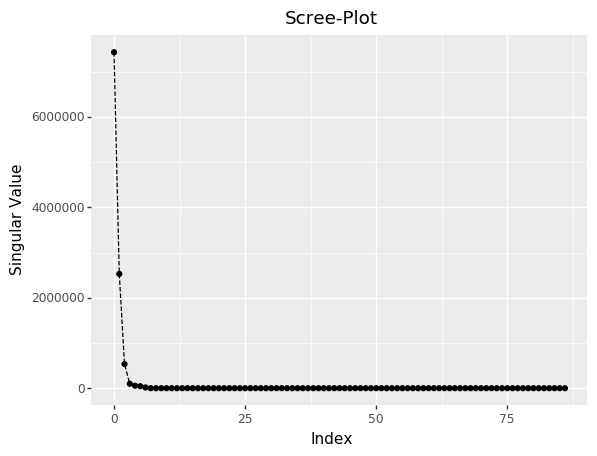

In [24]:
#load the dataset and preforms preproccesing
X,y = load_data("kc_house_data.csv")
w,D = fit_linear_regression(X,y)
#plots the singular value plots
print(plot_singular_values(D).draw());
print("Smallest Singular Value is {:.11f}".format(float(D[-1])));

We can learn from the singular values plot that there are 3 features that are more significant from the rest. The first two are very significant for our model, and most of the explained variance is embedded in them. 

We can see that the smallest singular value is 0.02617359325, which is small compare to the others, but not **that** close to zero, and therefor we can say that X is not close to being singular (since if the smallest sv was 0, it was singular).

**16. Putting it all together 2**

Next we will fit a model and test it over the data.  

Next, over the 3/4 of the data, considered as training set perform the following: 
For every p in {1, 2, ..., 100} fit a model based on the first p% of the training set. 

Then using the ‘predict‘ function test the performance of the fitted model on the test-set.

• Add to your answers PDF the plot of the MSE over the test set as a function of p%.

• Explain the results you got.


In [25]:
def split_data(X,y,prec, transposed=True):
    """
    Split given data X and response y to test and train by precentage.
    :param X: Data matrix
    :param y: a response vector
    :param prec: precentage of test data
    :param transposed: True if X rows are features, False if rows are observations
    return X_train - data matrix train set
            y_train - response vector train set
            X_test - data matrix test set
            y_test - response vector test set
    """
    X = X if transposed else X.T
    #create an array of all indices
    all_idx = np.arange(X.shape[1])
    #pick random indices for test
    test_idx = np.random.choice(all_idx, int(len(all_idx)*0.25), replace=False)
    #save the rest of the indices
    train_idx = list(set(all_idx)-set(test_idx))

    X_train, y_train, X_test, y_test = X[:,train_idx], y[train_idx], X[:,test_idx], y[test_idx]
    
    return X_train, y_train, X_test, y_test

In [26]:
np.random.seed(8)
X_train, y_train, X_test, y_test = split_data(X,y,0.25,True)

In [27]:
p_dict = {"p":[],"mse":[]}
for p in range(1,101):
    X_train_i = np.arange(X_train.shape[1])
    
    p_idx = np.random.choice(X_train_i, int(len(X_train_i)*(p/100)), replace=False)
  
    X_train_p, y_train_p = X_train[:,p_idx], y_train[p_idx]
    
    w, D = fit_linear_regression(X_train_p, y_train_p)
    y_hat = predict(X_test,w)
    mse_score = mse(y_test,y_hat)
    
    p_dict["p"].append(p/100)
    p_dict["mse"].append(mse_score)

In [28]:
df_p = pd.DataFrame.from_dict(p_dict)

100% mse is 28901379173.362, 1% mse is 53012122924.499, which is bigger by 1.834


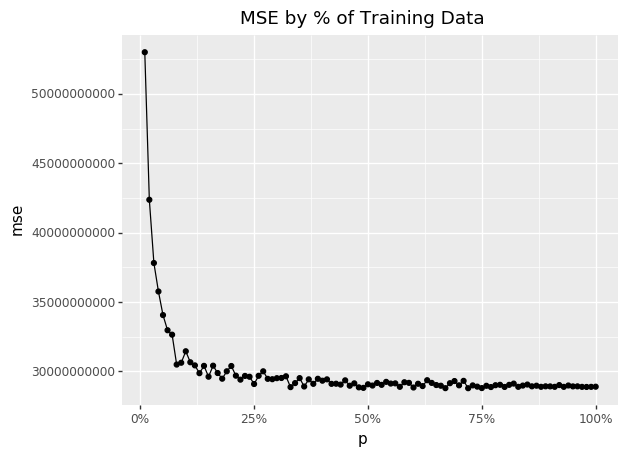

In [29]:
(ggplot(df_p,aes(x="p",y="mse")) + geom_line() + geom_point() + labs(title="MSE by % of Training Data") +\
scale_x_continuous(labels=percent_format())).draw();
max_mse, min_mse = round(df_p.mse.iloc[-1],3), round(df_p.mse.iloc[0],3)
print("100% mse is {}, 1% mse is {}, which is bigger by {}".format(max_mse, min_mse, round(min_mse/max_mse,3)))

We can see that as bigger our training set is (means more examples), as better our model will be (smaller error). This is what we expected to see. When we have more examples, we "teach" or "train" the computer to know more, and by that the model can give us better results because it has more "experience".

**17. Basics in feature selection: In the linear model.py file, implement a function named ‘feature evaluation‘.**


In [30]:
def single_plot(row, y,feature_name):
    var_y = (np.var(y))**0.5
    cov = (np.cov(row,y)[1][0])
    var_xi = (np.var(row))**0.5
    corr = round(cov/(var_y*var_xi),3)
    df = pd.DataFrame({"x":row,"y":y})
    return df, corr

def feature_evaluation(X, y):
    list_of_plots = []
    for i in range(len(X)):
        row = X[i]
        #if row is a categorical variable, skip. notice ones vector also skipped
        if np.array_equal(row, row.astype(bool)): 
            continue
        else:
            feature = data.columns[i]         
            df, corr = single_plot(row,y,feature)
            p = ggplot(df) + geom_point(aes(x="x",y="y")) +\
                labs(x=feature,y="Price",title="feature:{}, corr={}".format(feature,corr))
            list_of_plots.append(p)
    return list_of_plots

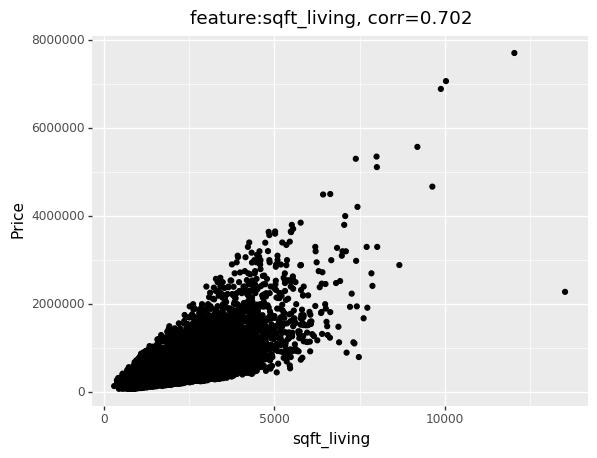

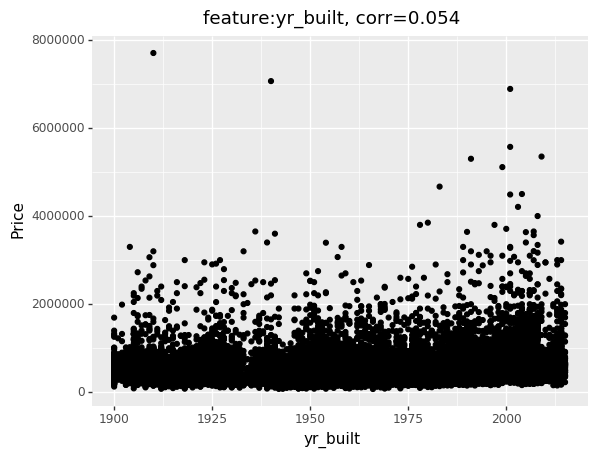

In [31]:
plotlist = feature_evaluation(X,y)

plotlist[2].draw(), plotlist[9].draw();

**In your answers PDF add the graphs of these two chosen features and explain how do you conclude if they are beneficial or not:**

I chose the sqft_living and yr_built variables as the two features I want to discuss.
We can see that sqft living has a high correlation with the price, and as bigger the sqft living, as bigger the price. Therfor I would say that this feature is very beneficial to our model.
We can also see that yr_built vs. price graph is very random and messy. It's a shapless graph and the two variables have low correlation. I would say that this feature is not much beneficial to our model.